In [30]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
from classes import classes
from torch.utils.data.sampler import SubsetRandomSampler

data_dir = 'Training'
valid_size = 0.2

transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
                               
# obtain training indices that will be used for validation
num_train = len(dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=32,
                                           sampler=train_sampler,
                                           num_workers=4)

valid_loader = torch.utils.data.DataLoader(dataset,
                                           batch_size=32,
                                           sampler=valid_sampler,
                                           num_workers=4)


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(len(train_loader), len(valid_loader))
classes.index('Apricot')

cuda:0
1330 333


13

(3, 32, 32)
Apple Red 2


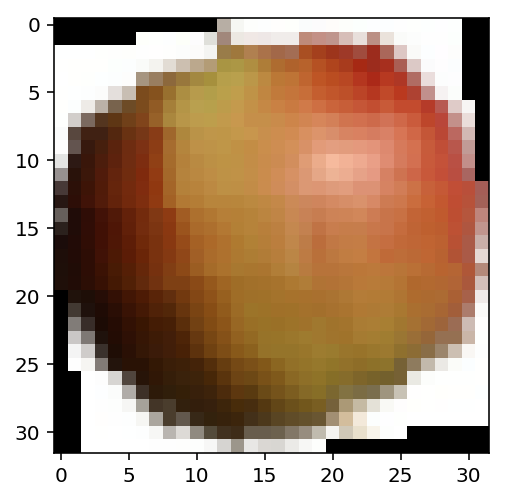

In [31]:
# Run this to test your data loader
images, labels = next(iter(train_loader))
images = images.numpy()
print(images[0].shape)
plt.imshow(np.transpose(images[13] / 2 + 0.5, (1, 2, 0)))
print(classes[labels[13].item()])

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # convolutional layer (sees 16x16x16 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 700) # 64 * 4 * 4 = 1024
        
        # linear layer (700 -> 500)
        self.fc2 = nn.Linear(700, 500)
        
        # linear layer (500 -> 300)
        self.fc3 = nn.Linear(500, 300)
        
        # linear layer (300 -> 103)
        self.fc4 = nn.Linear(300, 103)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten image input [batch_size, 64 * 4 * 4] = [20, 1024]
        x = x.reshape(-1, 64 * 4 * 4) 
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 2nd hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 3nd hidden layer, with relu activation function
        x = F.relu(self.fc3(x))
        
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x



In [33]:
# create a complete CNN
model = Net()

# move tensors to GPU if CUDA is available
torch.cuda.empty_cache()
model.to(device)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=700, bias=True)
  (fc2): Linear(in_features=700, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=300, bias=True)
  (fc4): Linear(in_features=300, out_features=103, bias=True)
  (dropout): Dropout(p=0.25)
)

In [34]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

In [35]:

# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    
    # train the model #
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # backward pass:
        loss.backward()
        
        # apply gradient descent parameter update
        optimizer.step()
        
        # update training loss
        train_loss += loss.mean()
        
    # validate the model 
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        
        # forward pass the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update average validation loss 
        valid_loss += loss.mean()
    
    # calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_fruit.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.266652 	Validation Loss: 1.721976
Validation loss decreased (inf --> 1.721976).  Saving model ...
Epoch: 2 	Training Loss: 0.850215 	Validation Loss: 0.433040
Validation loss decreased (1.721976 --> 0.433040).  Saving model ...
Epoch: 3 	Training Loss: 0.486461 	Validation Loss: 0.215596
Validation loss decreased (0.433040 --> 0.215596).  Saving model ...
Epoch: 4 	Training Loss: 0.302794 	Validation Loss: 0.129486
Validation loss decreased (0.215596 --> 0.129486).  Saving model ...
Epoch: 5 	Training Loss: 0.206646 	Validation Loss: 0.075981
Validation loss decreased (0.129486 --> 0.075981).  Saving model ...
Epoch: 6 	Training Loss: 0.155513 	Validation Loss: 0.050365
Validation loss decreased (0.075981 --> 0.050365).  Saving model ...
Epoch: 7 	Training Loss: 0.123482 	Validation Loss: 0.048219
Validation loss decreased (0.050365 --> 0.048219).  Saving model ...
Epoch: 8 	Training Loss: 0.100218 	Validation Loss: 0.094526
Epoch: 9 	Training Loss: 0.087718 

In [36]:
model.load_state_dict(torch.load('model_fruit.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [40]:
from classes import classes

test_dir = 'Test'
test_data = datasets.ImageFolder(test_dir, transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, 
    num_workers=4, shuffle=True)



In [43]:
model.eval()
accuracy = 0
for batch_idx, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    
    output = model(data)
    for i in range(output.shape[0]):
        guess = (output[i] == output[i].max()).nonzero()
        if guess == target[i].cuda():
            accuracy += 1
print('accuracy: ', accuracy / (len(test_loader) * test_loader.batch_size))

accuracy:  0.9852150537634409


In [74]:
test_loss = 0.0
class_correct = list(0. for i in range(103))
class_total = list(0. for i in range(103))

model.eval()

for batch_idx, (data, target) in enumerate(test_loader):
    # move tensors to GPU if CUDA is available
    data, target = data.to(device), target.to(device)
    
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(output.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(103):
    if class_total[i] > 0:
        print('%5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('%5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.061144

Apple Braeburn: 99% (163/164)
Apple Crimson Snow: 100% (148/148)
Apple Golden 1: 99% (163/164)
Apple Golden 2: 100% (164/164)
Apple Golden 3: 100% (161/161)
Apple Granny Smith: 100% (164/164)
Apple Pink Lady: 100% (152/152)
Apple Red 1: 89% (146/164)
Apple Red 2: 100% (164/164)
Apple Red 3: 100% (144/144)
Apple Red Delicious: 100% (166/166)
Apple Red Yellow 1: 75% (123/164)
Apple Red Yellow 2: 100% (219/219)
Apricot: 100% (164/164)
Avocado: 100% (143/143)
Avocado ripe: 100% (166/166)
Banana: 100% (166/166)
Banana Lady Finger: 100% (152/152)
Banana Red: 98% (164/166)
Cactus fruit: 91% (152/166)
Cantaloupe 1: 100% (164/164)
Cantaloupe 2: 99% (163/164)
Carambula: 87% (146/166)
Cherry 1: 100% (164/164)
Cherry 2: 100% (246/246)
Cherry Rainier: 100% (246/246)
Cherry Wax Black: 100% (164/164)
Cherry Wax Red: 100% (164/164)
Cherry Wax Yellow: 100% (164/164)
Chestnut: 100% (153/153)
Clementine: 93% (156/166)
Cocos: 95% (159/166)
Dates: 100% (166/166)
Granadilla: 100% (166/1

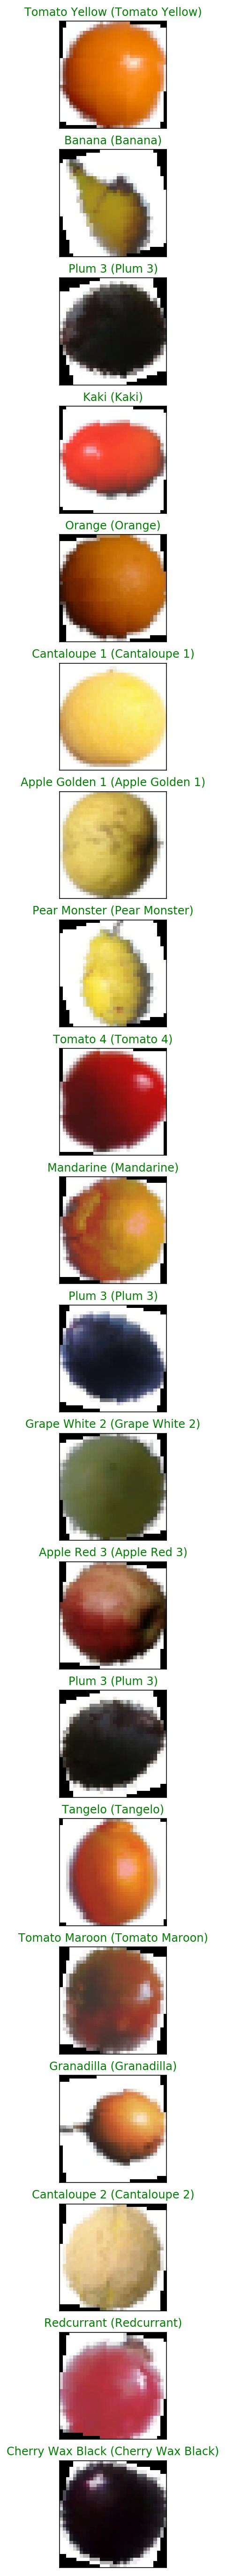

In [73]:
# predict 20 images 
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

images = images.to(device)

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(50, 50))
for idx in np.arange(20):
    ax = fig.add_subplot(20, 1, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx].cpu() / 2 + 0.5, (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))